In [1]:
from ftag.hdf5 import H5Reader # I use ftag tools to read the file
from ftag import Cuts, Flavour, Flavours
from puma.hlplots import AuxResults, Tagger
from puma.utils.vertexing import calculate_vertex_metrics, build_vertices, clean_reco_vertices, clean_truth_vertices
from puma import Histogram, HistogramPlot
import numpy as np

# You need to install JAX to be able to run these.
from puma.utils.billoir_vertex_fit import billoir_vertex_fit, billoir_forward
import jax.numpy as jnp


In [2]:
def leading_jet(jet):
    return jet["jetPtRank"] == 0
    
def jet_flavour(jet, f=""):
    if f == "b": return jet["HadronConeExclTruthLabelID"] == 5
    elif f == "c": return jet["HadronConeExclTruthLabelID"] == 4
    elif f == "light": return jet["HadronConeExclTruthLabelID"] == 0
    else:  return jet ["HadronConeExclTruthLabelID"] >= 0
            


In [3]:
def MaskTracks(my_data, n_jets, n_tracks):

    n_real_tracks = np.repeat(my_data["jets"]["n_tracks"], n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks
    track_indices = np.tile(
         np.arange(0,n_tracks,dtype=np.int32),
         n_jets,
    ).reshape(n_jets, n_tracks)
    
    track_mask = np.where(track_indices < n_real_tracks, 1, 0)
    
    return track_mask, n_real_tracks
    
def TransformData(my_data, n_tracks=40):

    # Function to calculate the track parameters in the perigree representation.
    # Returns data x with the format n_jets x n_tracks x n_parameters
    # The n_parameters will first have the variables needed for the billoir fit, some will have to be build by hand because not everything is available

    n_jets, max_tracks = my_data["tracks"].shape

    track = my_data["tracks"][:, 0:n_tracks]
    jet = my_data["jets"][:] # Only needed if you need to calculate the track phi from dphi.

    # Start by getting a mask of the real tracks

    # Get real tracks
    track_mask, n_real_tracks = MaskTracks(my_data, n_jets, n_tracks)

    # Compute Input Variables for Billoir Vertex Fit
    ### set parameters for dummy tracks to 1. They will be masked out by the track weight and if you choose a very low value the fit will not work well.

    d0 = jnp.where(track_mask == 0, 1, track["d0RelativeToBeamspot"])
    z0 = jnp.where(track_mask == 0, 1, track["z0RelativeToBeamspot"]) 
    
    jet_phi = jnp.repeat(jet["phi"], n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks
    phi    = track["phi"] #
    #phi = jet_phi + track["dphi"] # if track phi is missing you may want to do this instead  + is the correct sign
    phi = jnp.where(track_mask == 0, 1, phi)

    #print(phi[0], " vs ", track["phi"][0])
    #i, j = 1,1
    #print("Check computation of dphi ", jet_phi[i][j] - track["dphi"][i][j], " = ? = ", phi[i][j])

    theta  = jnp.where(track_mask == 0, 1, track["theta"])
    rho    = jnp.where(track_mask == 0, 1, track["qOverP"]*2*0.2299792*0.001/jnp.sin(track["theta"]))

    d0_error     = jnp.where(track_mask == 0, 1, track["d0RelativeToBeamspotUncertainty"])
    z0_error     = jnp.where(track_mask == 0, 1, track["z0RelativeToBeamspotUncertainty"])

    phi_error    = jnp.where(track_mask == 0, 1, track["phiUncertainty"])
    theta_error  = jnp.where(track_mask == 0, 1, track["thetaUncertainty"])

    rho_error    = jnp.where(track_mask == 0, 1, track["qOverP"]*2*0.2299792*0.001/jnp.sin(track["theta"]))

    track_origin = jnp.where(track_mask == 0, 1, track["GN2v01_aux_TrackOrigin"])
    track_vertex = jnp.where(track_mask == 0, 1, track["GN2v01_aux_VertexIndex"])
     
    x = jnp.stack([d0, z0, phi, theta, rho, d0_error, z0_error, phi_error, theta_error, rho_error, track_origin, track_vertex, n_real_tracks], axis = 2)
    
    return x, track, track_mask


In [4]:
def CalculateDistance(sv_x, sv_y, sv_z, pv_x, pv_y, pv_z):
    
    Lxy = np.sqrt((sv_x - pv_x)**2 + (sv_y- pv_y)**2)
    Lxyz = np.sqrt((sv_x - pv_x)**2 + (sv_y- pv_y)**2 +  (sv_z- pv_z)**2)
    return Lxy, Lxyz


# Get the vertex indices and track weights! Which tracks belong to which vertex according? The track origin is used for the cleaning
def GetTrackWeights(track_data, incl_vertexing=False, truth=False, max_sv=1):

    if truth:
        raw_vertex_index = track_data["ftagTruthVertexIndex"] # your raw vertex
        track_origin = track_data["ftagTruthOriginLabel"]

    else:
        # Reco Level
        raw_vertex_index = track_data["GN2v01_aux_VertexIndex"] # your raw vertex
        track_origin = track_data["GN2v01_aux_TrackOrigin"]

    # Now clean vertices
    vertex_index  = raw_vertex_index.copy()

    # Prepare mask for filling up
    #dummy_track_weights = jnp.zeros((vertex_index.shape[0], max_sv, n_tracks))
    track_weights = jnp.zeros((vertex_index.shape[0], max_sv, n_tracks))

    #track_weights = jnp.where(dummy_track_weights == 0, 0, dummy_track_weights) #why np.nan?
    
    for i in range(my_data["tracks"]["GN2v01_aux_VertexIndex"].shape[0]):

        if truth:
            vertex_index[i] = clean_truth_vertices(
                vertex_index[i], track_origin[i], incl_vertexing=incl_vertexing
            )
        
        else:
            vertex_index[i] = clean_reco_vertices(
                vertex_index[i], track_origin[i], incl_vertexing=incl_vertexing
            )

        vertices = build_vertices(vertex_index[i]) # Convert indices to true/false

        for j in range(0, max_sv):
            try:
                track_weights = track_weights.at[i, j].set(vertices[j])
            except:
                continue


    return track_weights, vertex_index


In [5]:
def ProcessTruthHadrons(my_data, n_jets, drop_unrelated_hadrons = True):

    hadron = my_data["truth_hadrons"][:] # Only needed if you need to calculate the track phi from dphi.
    max_n_hadrons = hadron["parentBarcode"].shape[1]
    
    print("Max number of truth hadrons in your sample: ", max_n_hadrons)

    # Make your own loop
    child = []
    parent = []

    for i in range(0, n_jets):
        child.append(np.isin(hadron["parentBarcode"][i], hadron["barcode"][i]))
        parent.append(np.isin(hadron["barcode"][i], hadron["parentBarcode"][i]))
            
    child = np.where(hadron["barcode"] == -1, False,np.array(child))
    parent = np.where(hadron["barcode"] == -1, False, np.array(parent))

    real_hadron = np.where(hadron["barcode"] == -1, False, True)
    one_hadron = np.where(np.sum(real_hadron, axis =1) ==1, True, False)

    label_hadron_index = np.where(np.sum(parent) > 0, np.argmax(parent, axis=1), np.nan)

    label_hadron_index = np.where(one_hadron == True, 0, label_hadron_index)
    child_hadron_index = np.where(np.sum(child) > 0 , np.argmax(child, axis=1), np.nan) # argmax takes the first argument from the list
    
    child2_hadron_index = np.full(child_hadron_index.shape, np.nan)

    for i in range (0, n_jets):
        if (np.sum(child[i]) >= 2): 
            for x in (np.argwhere(child[i] == 1)):
                if x != child_hadron_index[i]:
                    child2_hadron_index[i] = x
                else:
                    continue
            
    hadron_indices = np.stack( (label_hadron_index, child_hadron_index,  child2_hadron_index), axis = 1)

    print("Total number of jets = ", n_jets)
    n_one = np.sum(one_hadron)
    
    #family = np.where(hadron["barcode"] == -1, False, np.isin(hadron["barcode"], hadron["parentBarcode"]) | np.isin(hadron["parentBarcode"], hadron["barcode"]))
    family = np.where(hadron["barcode"] == -1, False, child | parent)
    unrelated = ((np.sum(real_hadron, axis =1) > 1) & (np.sum(family, axis =1) <= 1))

    good_jets = ((one_hadron) | (np.sum(family, axis =1) > 1))

    n_decay_chain = np.sum(np.where(np.sum(family, axis =1) > 1, True, False))
    n_unrelated = np.sum(unrelated)
    print(" -- Number of jets multiple unrelated hadrons = ",n_unrelated)

    print(" -- Number of jets with only 1 SV = ",n_one)

    print(" -- Number of jets with a decay chain = ",n_decay_chain)
    if ( n_one + n_decay_chain + n_unrelated != n_jets): print("Warning! The sum of the 3 types of jets does not add up to the total number of jets!")

    print("   --> # jets with 2 SVs: = ",np.sum(np.where(np.sum(family, axis =1) == 2, True, False)))
    print("   --> # jets with 3+ SVs: = ",np.sum(np.where(np.sum(family, axis =1) > 2, True, False)))
    print("   --> # jets with 4+ SVs: = ",np.sum(np.where(np.sum(family, axis =1) > 3, True, False)))

    print(np.sum(good_jets), " good jets (drop the jets with more than one unrelated hadron)")

    
    return good_jets, hadron_indices, parent, child, one_hadron


def GetTruthSVdisplacement(hadrons, hadron_indices):

    
    hadron_displacement = np.full((hadrons.shape[0], hadrons.shape[1],3), np.nan)

    for i in range(0, hadrons.shape[0]):
        for j in range(0,  hadrons.shape[1]):
            try:
                x = int(hadron_indices[i,j])
            except:
                continue

            hadron_displacement[i,j, 0] = hadrons["displacementX"][i, x]
            hadron_displacement[i,j, 1] = hadrons["displacementY"][i, x]
            hadron_displacement[i,j, 2] = hadrons["displacementZ"][i, x]

    return hadron_displacement

    

def AssociateTracksToHadron(my_data, drop_unrelated_hadrons = True):
        
    n_jets, max_tracks = my_data["tracks"].shape
    #track = my_data["tracks"][:, 0:n_tracks]
    
    good_jets, hadron_indices, parent, child, one_hadron = ProcessTruthHadrons(my_data, n_jets, drop_unrelated_hadrons)

    # Start by getting a mask of the real tracks
    # Get real tracks
    track_mask, n_real_tracks = MaskTracks(my_data, n_jets, n_tracks)

    if drop_unrelated_hadrons:
        my_good_jets = np.repeat(good_jets, n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks
        jet_track_mask = np.where(my_good_jets == True, 1, 0)
        track_mask = track_mask & jet_track_mask


    inclusive_vertex = []
    exclusive_vertex = []
    
    for i in range(0, n_jets):
        tmp_inclusive = np.where(track_mask[i] == 0, 0, np.isin(np.where(my_data["tracks"]["ftagTruthParentBarcode"][i] < 0, np.nan, my_data["tracks"]["ftagTruthParentBarcode"][i]),  my_data["truth_hadrons"]["barcode"][i]))
        if np.sum(tmp_inclusive) <= 1: 
            inclusive_vertex.append(np.zeros(tmp_inclusive.shape))
        else:
             inclusive_vertex.append(tmp_inclusive)        
        tmp_exclusive_list = []
        for j in range(0, my_data["truth_hadrons"]["barcode"].shape[1]):
            tmp_exclusive = np.where(track_mask[i] == 0, 0, np.isin(np.where(my_data["tracks"]["ftagTruthParentBarcode"][i] < 0, np.nan, my_data["tracks"]["ftagTruthParentBarcode"][i]),  my_data["truth_hadrons"]["barcode"][i][j]))
            if np.sum(tmp_exclusive) <= 1:
                tmp_exclusive_list.append(np.zeros(tmp_exclusive.shape))
            else:
                tmp_exclusive_list.append(tmp_exclusive)

        exclusive_vertex.append(np.array(tmp_exclusive_list)) 

    inclsuive_vertex = np.array(inclusive_vertex)
    exclusive_vertex = np.array(exclusive_vertex)
                                        
    return inclusive_vertex, exclusive_vertex, track_mask, jet_track_mask


In [6]:
def GetCuts(sample):

    if sample == "ttbar":
        sample_str = "$t\\overline{t}$"
        cuts = [
            ("pt", ">=", 20000),
            ("pt", "<=", 250000),
            ("eta", ">", -2.5),
            ("eta", "<", 2.5),
            ("HadronConeExclTruthLabelID", ">=", 4),
            ("HadronConeExclTruthLabelID", "<=", 5),
            #("jetPtRank", "==", 0)


        ]
        cut_str = "20 < $p_T$ < 250 GeV, $|\\eta| < 2.5$"
            
    elif sample == "zprime":
        sample_str = "Z'"
        cuts = [
            ("pt", ">=", 250000),
            ("pt", "<=", 6000000),
            ("eta", ">", -2.5),
            ("eta", "<", 2.5),
            #("HadronConeExclTruthLabelID", ">=", 4),
            #("HadronConeExclTruthLabelID", "<=", 5)

        ]
        cut_str = "250 < $p_T$ < 6000 GeV, $|\\eta| < 2.5$"
    

    return cuts, cut_str



In [7]:
import h5py

def ListVariables(file):
    with h5py.File(file_path, "r") as f:
        print(f.keys())
        for k in list(f.keys()):
            print(k)
            print(f[k].dtype.fields.keys())

    return 

In [87]:
### Read your data!

sample = "ttbar"
mc = "MC23a"
#my_dir = "NDIVE_final_v2/" #"GN2_NDIVE/" "Downloaded/"#
#my_dir = "Testing EMPFlow.json config file/"
my_dir="OpenDataset_v4"
output = "final_plots/"

n_jets = 100 #150000
n_tracks = 40 # max 40

## Choose what to read
#file_path =  "/fs/ddn/sdf/group/atlas/d/lapereir/GN2/"+my_dir+"/"+mc+"_"+"new-"+sample+".h5"

file_path = "/fs/ddn/sdf/group/atlas/d/lapereir/GN2/Test/test_EMPFlow_OpenData_config.h5"
print(file_path)
#file_path =  "/fs/ddn/sdf/group/atlas/d/lapereir/GN2/"+my_dir+"/holi.h5"
#file_path =  "/fs/ddn/sdf/group/atlas/d/lapereir/GN2/"+my_dir+"/MC23a_new-ttbar.h5"
#file_path = "/sdf/home/l/lapereir/software/FTAG/puma/my_scripts/open_ttbar.h5"

# If you need to print out the containers and variables in your file
ListVariables(file_path)

my_cuts, cut_str = GetCuts(sample)


track_var = ["d0", "z0SinTheta", "dphi", "d0Uncertainty", "z0SinThetaUncertainty", "phiUncertainty", "thetaUncertainty", "qOverPUncertainty", "qOverP", "deta", "theta", "dphi", "phi"] # for vertex fit
track_var += ["d0RelativeToBeamspot", "d0RelativeToBeamspotUncertainty","z0RelativeToBeamspot", "z0RelativeToBeamspotUncertainty",  "ftagTruthOriginLabel",  "GN2v01_aux_TrackOrigin", "GN2v01_aux_VertexIndex",  "ftagTruthVertexIndex", "ftagTruthParentBarcode"]
#track_var=["ftagTruthOriginLabel","ftagTruthVertexIndex", 'SV1VertexIndex', 'JFVertexIndex', "GN2v01_aux_TrackOrigin"]
jet_var = ["eventNumber","GN2v01_pb", "GN2v01_pc", "GN2v01_pu", "n_tracks", "jetPtRank", "phi", "eta", "HadronConeExclTruthLabelID", "HadronConeExclExtendedTruthLabelID", "HadronConeExclTruthLabelPdgId", "HadronConeExclTruthLabelLxy", "SV1_Lxy", "JetFitterSecondaryVertex_displacement2d", "SV1_L3d", "JetFitterSecondaryVertex_displacement3d", "JetFitter_nVTX", "mcEventWeight", "nPrimaryVertices"] # phi is needed for vertex fit if track phi is not available # v00 instead of v01
#jet_var +=['PVtoBeam_displacement_X', 'PVtoBeam_displacement_Y', 'PVtoBeam_displacement_Z',]
# "primaryVertexZ", "primaryVertexX", "primaryVertexY", "beamspotX", "beamspotY", "beamspotZ", "Truth_primaryVertexX", "Truth_primaryVertexY", "Truth_primaryVertexZ", 
truth_hadrons = ['pt', 'mass', 'energy', 'eta', 'phi', 'deta', 'dphi', 'dr', 'displacementX', 'displacementY', 'displacementZ','Lxy', 'charge', 'flavour', 'pdgId', 'barcode', 'parentBarcode', 'valid',  'decayVertexDPhi', 'decayVertexDEta'] # 'prodVtx_x', 'prodVtx_y', 'prodVtx_z',  'decayVtx_x', 'decayVtx_y', 'decayVtx_z', 

kinematic_cuts = Cuts.from_list(my_cuts)
print(kinematic_cuts)

## read it!
my_reader = H5Reader(file_path, precision="full", shuffle=False, batch_size=100)
#my_data = my_reader.load({"jets": jet_var, "tracks" : track_var}, num_jets=n_jets, cuts=kinematic_cuts)

my_data = my_reader.load({"jets": jet_var, "tracks" : track_var, "ConeExclFinalLabels" : truth_hadrons, "truth_hadrons" : truth_hadrons}, num_jets=n_jets, cuts=kinematic_cuts)
#my_data = my_reader.load({"jets": jet_var, "tracks" : track_var, "ConeExclFinalLabels" : truth_hadrons, "truth_hadrons" : truth_hadrons}, cuts=kinematic_cuts)

#my_data = my_reader.load({"jets": jet_var, "tracks" : track_var}, cuts=kinematic_cuts,  num_jets=n_jets) # "ConeExclFinalLabels" : truth_hadrons}, cuts=kinematic_cuts) # num_jets=n_jets,


# now you will be able to read 
# --- data["jets"] with shape n_jets (x n_jet_var tuple)
# --- data["tracks"] with shape n_jets x n_tracks (x n_track_var tuple)
# Note that since jet_var and track_var are stored in a tuple instead of an array when using H5Reader, therefore you will need to convert them to arrays in order to run NDIVE!


/fs/ddn/sdf/group/atlas/d/lapereir/GN2/Test/test_EMPFlow_OpenData_config.h5
<KeysViewHDF5 ['ConeExclFinalLabels', 'eventwise', 'jets', 'tracks', 'truth_hadrons']>
ConeExclFinalLabels
dict_keys(['valid'])
eventwise
dict_keys(['first_jet_index', 'n_jets', 'primaryVertexToBeamDisplacementX', 'primaryVertexToBeamDisplacementY', 'primaryVertexToBeamDisplacementZ', 'primaryVertexToTruthVertexDisplacementX', 'primaryVertexToTruthVertexDisplacementY', 'primaryVertexToTruthVertexDisplacementZ', 'truthPrimaryVertexX', 'truthPrimaryVertexY', 'truthPrimaryVertexZ'])
jets
dict_keys(['GN2v01_pb', 'GN2v01_pc', 'GN2v01_pu', 'GN2v01_ptau', 'SV1_correctSignificance3d', 'softMuon_pt', 'softMuon_dR', 'softMuon_eta', 'softMuon_phi', 'softMuon_qOverPratio', 'softMuon_momentumBalanceSignificance', 'softMuon_scatteringNeighbourSignificance', 'softMuon_pTrel', 'softMuon_ip3dD0', 'softMuon_ip3dZ0', 'softMuon_ip3dD0Significance', 'softMuon_ip3dZ0Significance', 'softMuon_ip3dD0Uncertainty', 'softMuon_ip3dZ0Uncert

Sample path:  Testing EMPFlow.json config file/
Sample path:  Testing EMPFlow.json config file/


Text(0.5, 1.0, 'Track Origin Confusion Matrix')

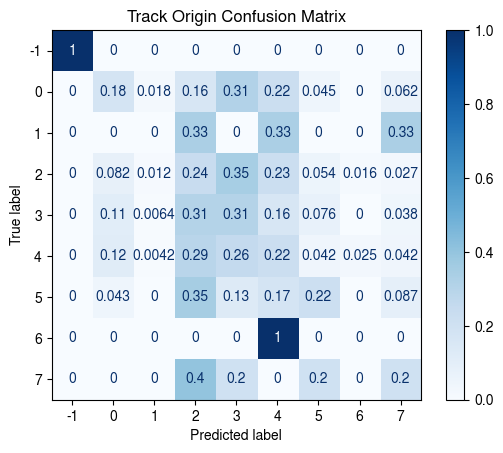

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


print("Sample path: ", my_dir)

# Sample input arrays
true_labels = my_data["tracks"]["ftagTruthOriginLabel"]
try:
    pred_labels = my_data["tracks"]["GN2v01_aux_TrackOrigin"]
except:
    pred_labels = my_data["tracks"]["GN2v01_20231205_TrackOrigin"]


#for i in range(0, 10):
#    print(true_labels[i])
#    print(pred_labels[i])

print("Sample path: ", my_dir)

# Flatten the arrays
true_labels_flat = true_labels.flatten()
pred_labels_flat = pred_labels.flatten()

# Compute the confusion matrix
cm = confusion_matrix(true_labels_flat, pred_labels_flat, normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(-1, 8))
disp.plot(cmap=plt.cm.Blues)

plt.title('Track Origin Confusion Matrix')


In [9]:
good_jets, hadron_indices, parent, child, one_hadron = ProcessTruthHadrons(my_data, my_data["jets"].shape[0], drop_unrelated_hadrons=True)
truth_hadron_displacement = GetTruthSVdisplacement(my_data["truth_hadrons"], hadron_indices)

Max number of truth hadrons in your sample:  5
Total number of jets =  50000
 -- Number of jets multiple unrelated hadrons =  1786
 -- Number of jets with only 1 SV =  9516
 -- Number of jets with a decay chain =  38698
   --> # jets with 2 SVs: =  28988
   --> # jets with 3+ SVs: =  9710
   --> # jets with 4+ SVs: =  426
48214  good jets (drop the jets with more than one unrelated hadron)


In [10]:
# Process variables required for Vertex fit
# Get variables for tracks with perigree representation
x, track_data, mask_tracks = TransformData(my_data, n_tracks = n_tracks)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
inclusive_vertex = True
basic_extra_string = "_InclusiveVertex"
extra = " (Inclusive Vertex)"
max_sv = 1
if inclusive_vertex == False:
    basic_extra_string = "_NonInclusiveVertex"
    extra = ""
    max_sv = 3

extra_string = basic_extra_string

In [12]:
# Get Vertex Index, where are the secondary vertices?
reco_track_weights, reco_vertex_index = GetTrackWeights(track_data, incl_vertexing=inclusive_vertex, truth=False, max_sv=max_sv) # if not inclusive you can choose to store more than one vertex i.e. max_sv != 1

In [15]:
truth_track_weights, truth_vertex_index = GetTrackWeights(track_data, incl_vertexing=inclusive_vertex, truth=True, max_sv=max_sv) 

In [14]:
inclusive_track_vertex, exclusive_track_vertex, vertex_track_mask, good_jet_mask = AssociateTracksToHadron(my_data)

Max number of truth hadrons in your sample:  5
Total number of jets =  50000
 -- Number of jets multiple unrelated hadrons =  1786
 -- Number of jets with only 1 SV =  9516
 -- Number of jets with a decay chain =  38698
   --> # jets with 2 SVs: =  28988
   --> # jets with 3+ SVs: =  9710
   --> # jets with 4+ SVs: =  426
48214  good jets (drop the jets with more than one unrelated hadron)


In [19]:
# In exclusive fits, we select the hadron with highest amount of tracks to fit, but we need the index
if inclusive_vertex == False: 
    print("Exclusive Fits select the hadron with highest number of tracks per vertex per each jet")           

    print("You set up max # SV = ", max_sv, " and your sample has at most ", exclusive_track_vertex.shape[1], " hadrons")
    if exclusive_track_vertex.shape[1] > max_sv: 
        print( " --> Dropping two hadrons beyond the allowed number of vertices")
        exclusive_track_vertex = exclusive_track_vertex[:, :max_sv,:]
    
    index_hadrons = np.argmax(np.sum(exclusive_track_vertex, axis=2), axis=1)
    index_truth_tracks = np.argmax(np.sum(truth_track_weights, axis=2), axis=1)
    index_reco_tracks = np.argmax(np.sum(reco_track_weights, axis=2), axis=1)


In [20]:
# Make your own track to vertex association at truth level

print("Inclusive Vertex = ", inclusive_vertex)

same = 0
different = 0

truth_same = 0
truth_different = 0

bad_jet = 0


for i in range(0, n_jets):       
    if inclusive_vertex == False:            
            
#inclusive_track_vertex, exclusive_track_vertex, vertex_track_mask, good_jet_mask = AssociateTracksToHadron(my_data)
        j = index_hadrons[i]
        k = index_truth_tracks[i]
        m = index_reco_tracks[i]
            
        if np.all(truth_track_weights[i, k, :] == exclusive_track_vertex[i, j]):
            truth_same += 1
        else:
            if good_jets[i] == False:
                bad_jet += 1
                continue
            truth_different += 1
            #print("Jet ", i)
            #print(truth_track_weights[i, k, :])
            #print(exclusive_track_vertex[i, j])
            #print(my_data["truth_hadrons"]["barcode"][i])
            #print(my_data["truth_hadrons"]["parentBarcode"][i])
            #print(my_data["tracks"]["ftagTruthParentBarcode"][i])

    else:            
        j, k, m = 0, 0, 0
        
        if np.all(truth_track_weights[i, j, :] == inclusive_track_vertex[i]):
            truth_same += 1
        else:
            if good_jets[i] == False: 
                bad_jet += 1
                continue
            truth_different += 1
            #print("Jet ", i)
            #print(truth_track_weights[i, 0, :])
            #print(" -> ", inclusive_track_vertex[i])
            #print(my_data["truth_hadrons"]["barcode"][i])
            #print(my_data["truth_hadrons"]["parentBarcode"][i])
            #print(my_data["tracks"]["ftagTruthParentBarcode"][i])


    if np.all(truth_track_weights[i, m, :] == reco_track_weights[i, k, :]):
        same += 1
    else:
        different += 1

print("Both Truth arrays are same for ", truth_same/(truth_same+truth_different)*100, "% of the jets")
print("  -->  From the remaining jets: ", bad_jet/(truth_different+bad_jet)*100, "% of are bad i.e. filtered out because they don't contain a clear parent hadron")
print("Reco and Truth Track Weights arrays are same for ", same/(same+different)*100, "% of the jets")

Inclusive Vertex =  True
Both Truth arrays are same for  96.77639328001983 % of the jets
  -->  From the remaining jets:  50.742027155036304 % of are bad i.e. filtered out because they don't contain a clear parent hadron
Reco and Truth Track Weights arrays are same for  14.090880912528672 % of the jets


In [21]:
# Flatten the number of hadrons for exclusive vertex fits
# Do fits with reco tracks 

# Only if you want to fit multiple vertices

# Need to fix this for the exclusive fits

seed = jnp.zeros((reco_track_weights.shape[0], 3))

if inclusive_vertex == False: 

    vertex_fit, vertex_covariance_fit, vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[np.arange(n_jets), index_reco_tracks]), jnp.array(seed[:]))
    truth_vertex_fit, truth_vertex_covariance_fit, truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[np.arange(n_jets), index_truth_tracks]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex
    Truth_displacement = truth_hadron_displacement[np.arange(n_jets), index_hadrons]

else:

    vertex_fit, vertex_covariance_fit, vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:,0,:]), jnp.array(seed[:]))
    truth_vertex_fit, truth_vertex_covariance_fit, truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:,0,:]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex
    Truth_displacement = truth_hadron_displacement[:,0]
    

# change dummy values (0 by default) to np.nan
vertex_fit = np.where(vertex_fit == 0, np.nan, vertex_fit)
truth_vertex_fit = np.where(truth_vertex_fit == 0, np.nan, truth_vertex_fit)


PVtoBeam_X = my_data["jets"]['PVtoBeam_displacement_X']
PVtoBeam_Y = my_data["jets"]['PVtoBeam_displacement_Y']
PVtoBeam_Z = my_data["jets"]['PVtoBeam_displacement_Z']



Billoir forward tracks
(40, 13)
Traced<ShapedArray(float32[40,13])>with<DynamicJaxprTrace(level=3/1)>
Estimating vertex from weights:
Traced<ShapedArray(float64[40])>with<DynamicJaxprTrace(level=3/1)>


In [22]:
# super truth i.e. select track weights from truth hadron information

if inclusive_vertex == False: 
    super_truth_vertex_fit, super_truth_vertex_covariance_fit, super_truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(exclusive_track_vertex[np.arange(n_jets), index_hadrons]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex
else:
    super_truth_vertex_fit, super_truth_vertex_covariance_fit, super_truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(inclusive_track_vertex), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex

super_truth_vertex_fit = np.where(super_truth_vertex_fit == 0, np.nan, super_truth_vertex_fit)

Displacement_x_super_truth_tracks = np.array(super_truth_vertex_fit[:, 0] - PVtoBeam_X) # need truth # the - will have to be a + when we use a newer sample vesion bc Dan changed the definition
Displacement_y_super_truth_tracks = np.array(super_truth_vertex_fit[:, 1] - PVtoBeam_Y) # need truth
Displacement_z_super_truth_tracks = np.array(super_truth_vertex_fit[:, 2] - PVtoBeam_Z) # need truth

Lxy_super_truth_tracks = np.sqrt( Displacement_x_super_truth_tracks**2 + Displacement_y_super_truth_tracks**2)
Lxyz_super_truth_tracks = np.sqrt( Displacement_x_super_truth_tracks**2 + Displacement_y_super_truth_tracks**2 + Displacement_z_super_truth_tracks**2)


In [23]:
# Do fits with reco tracks 

# Only if you want to fit multiple vertices

# Need to fix this for the exclusive fits
'''
seed = jnp.zeros((reco_track_weights.shape[0], 3))

for i in range(0, max_sv):
    if i == 0:
        vertex_fit, vertex_covariance_fit, vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:, i, :]), jnp.array(seed[:]))
        truth_vertex_fit, truth_vertex_covariance_fit, truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex
    else:
        tmp_vertex_fit, tmp_vertex_covariance_fit,tmp_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:, i, :]), jnp.array(seed[:]))
        tmp_truth_vertex_fit, tmp_truth_vertex_covariance_fit, tmp_truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex

        vertex_fit = np.concatenate((vertex_fit, tmp_vertex_fit), axis=0)
        vertex_covariance_fit = np.concatenate((vertex_covariance_fit, tmp_vertex_covariance_fit), axis=0)
        vertex_fit_chi2 = np.concatenate((vertex_fit_chi2, tmp_vertex_fit_chi2), axis=0)    

        truth_vertex_fit = np.concatenate((truth_vertex_fit, tmp_truth_vertex_fit), axis=0)
        truth_vertex_covariance_fit = np.concatenate((truth_vertex_covariance_fit, tmp_truth_vertex_covariance_fit), axis=0)
        truth_vertex_fit_chi2 = np.concatenate((truth_vertex_fit_chi2, tmp_truth_vertex_fit_chi2), axis=0)    


# change dummy values (0 by default) to np.nan
vertex_fit = np.where(vertex_fit == 0, np.nan, vertex_fit)
truth_vertex_fit = np.where(truth_vertex_fit == 0, np.nan, truth_vertex_fit)

if max_sv == 1: Truth_displacement = truth_hadron_displacement[:, 0, : ]
if max_sv == 2: Truth_displacement = np.concatenate((truth_hadron_displacement[:, 0, :], truth_hadron_displacement[:, 1, :]), axis = 0)
if max_sv == 3: Truth_displacement = np.concatenate((truth_hadron_displacement[:, 0, :], truth_hadron_displacement[:, 1, :], truth_hadron_displacement[:, 2, :]), axis = 0)

PVtoBeam_X = my_data["jets"]['PVtoBeam_displacement_X']
PVtoBeam_Y = my_data["jets"]['PVtoBeam_displacement_Y']
PVtoBeam_Z = my_data["jets"]['PVtoBeam_displacement_Z']

PVtoBeam_X = np.repeat(PVtoBeam_X, max_sv, axis=0)
PVtoBeam_Y = np.repeat(PVtoBeam_Y, max_sv, axis=0)
PVtoBeam_Z = np.repeat(PVtoBeam_Z, max_sv, axis=0)

'''

'\nseed = jnp.zeros((reco_track_weights.shape[0], 3))\n\nfor i in range(0, max_sv):\n    if i == 0:\n        vertex_fit, vertex_covariance_fit, vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:, i, :]), jnp.array(seed[:]))\n        truth_vertex_fit, truth_vertex_covariance_fit, truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex\n    else:\n        tmp_vertex_fit, tmp_vertex_covariance_fit,tmp_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:, i, :]), jnp.array(seed[:]))\n        tmp_truth_vertex_fit, tmp_truth_vertex_covariance_fit, tmp_truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex\n\n        verte

In [24]:

Displacement_x = np.array(vertex_fit[:, 0] - PVtoBeam_X) # the - will have to be a + when we use a newer sample vesion bc Dan changed the definition
Displacement_y = np.array(vertex_fit[:, 1] - PVtoBeam_Y)
Displacement_z = np.array(vertex_fit[:, 2] - PVtoBeam_Z)

Lxy = np.sqrt( Displacement_x**2 + Displacement_y**2)
Lxyz = np.sqrt( Displacement_x**2 + Displacement_y**2 + Displacement_z**2)


Truth_Displacement_x = Truth_displacement[:, 0]
Truth_Displacement_y = Truth_displacement[:, 1]
Truth_Displacement_z =Truth_displacement[:, 2]

Truth_Lxy = np.sqrt( Truth_Displacement_x**2 + Truth_Displacement_y**2)
Truth_Lxyz = np.sqrt( Truth_Displacement_x**2 + Truth_Displacement_y**2 + Truth_Displacement_z**2)

# This is not the error on the displacement but the error on the X, Y, Z position of the SV
Displacement_x_error = np.sqrt(vertex_covariance_fit[:, 0, 0])
Displacementx_y_error = np.sqrt(vertex_covariance_fit[:, 1, 1])
Displacement_z_error = np.sqrt(vertex_covariance_fit[:, 2, 2])


error_x = np.array(Truth_Displacement_x - Displacement_x)
error_y = np.array(Truth_Displacement_y - Displacement_y)
error_z = np.array(Truth_Displacement_z - Displacement_z)

significance_x = error_x/Displacement_x_error 
significance_y = error_y/Displacementx_y_error
significance_z = error_z/Displacement_z_error


# What if we use truth tracks instead?

Displacement_x_truth_tracks = np.array(truth_vertex_fit[:, 0] - PVtoBeam_X) # need truth # the - will have to be a + when we use a newer sample vesion bc Dan changed the definition
Displacement_y_truth_tracks = np.array(truth_vertex_fit[:, 1] - PVtoBeam_Y) # need truth
Displacement_z_truth_tracks = np.array(truth_vertex_fit[:, 2] - PVtoBeam_Z) # need truth

Lxy_truth_tracks = np.sqrt( Displacement_x_truth_tracks**2 + Displacement_y_truth_tracks**2)
Lxyz_truth_tracks = np.sqrt( Displacement_x_truth_tracks**2 + Displacement_y_truth_tracks**2 + Displacement_z_truth_tracks**2)



In [25]:
print(Displacement_x_error)

[0.12130674 0.20002796 0.         ... 0.12317299 0.13313494 0.12370771]


/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),


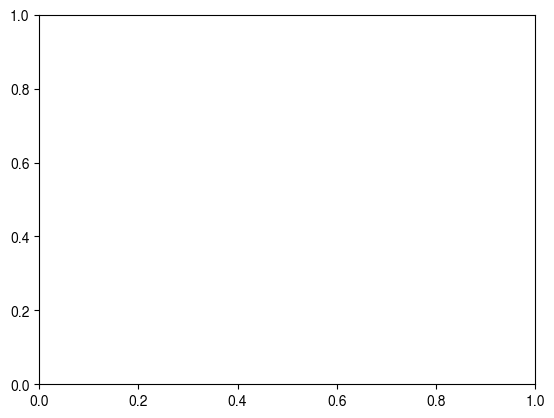

In [26]:
# DEBUGGING
# Plots track Phi and Calculated Track Phi
t = 0

stored = Histogram(my_data["tracks"]["phi"][:, t], label="track phi", histtype="step", alpha=1)

jet_phi = np.repeat(my_data["jets"]["phi"], n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks
calculated_track_phi = jet_phi + my_data["tracks"]["dphi"]

calculated = Histogram(calculated_track_phi[:, t], label="jet phi + track dphi", histtype="step", alpha=1)
        
        
# Initialise histogram plot
plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Phi [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=20,  # you can also define an integer number for the number of bins
        bins_range=(-3.5,3.5),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample,
        figsize=(6, 5),
        n_ratio_panels=1,
)
    
plot_histo.add(stored, reference=True)
plot_histo.add(calculated, reference=False)    
    
plot_histo.draw()
 
plot_histo.savefig(output+"Histogram_Calculate_TrackPhi.png", transparent=False)


In [27]:
i = 5

print(my_data["tracks"]["d0RelativeToBeamspot"][i][0],  my_data["tracks"]["d0"][i][0])
print(my_data["tracks"]["z0RelativeToBeamspot"][i][0],  my_data["tracks"]["z0SinTheta"][i][0], my_data["tracks"]["z0SinTheta"][i][0]/np.sin(my_data["tracks"]["theta"][i][0]) )

#print(np.sin(my_data["tracks"]["theta"][i]))
#print(PV_z[i] - ( my_data["tracks"]["z0RelativeToBeamspot"][i][0] - my_data["tracks"]["z0SinTheta"][i][0]/np.sin(my_data["tracks"]["theta"][i][0])))


-0.02180704 -0.019073486
-7.5152087 0.0018053055 0.002418773


/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),


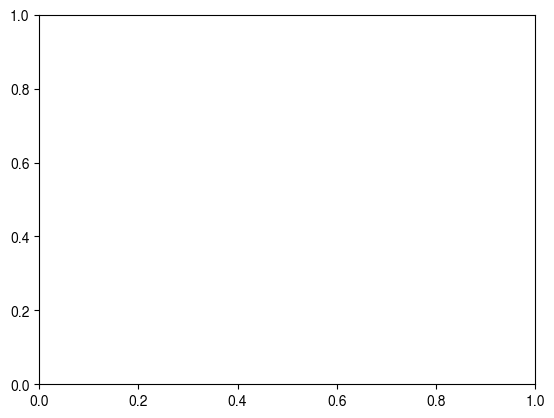

In [28]:
jets = my_data["jets"]

for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    truth_hist = Histogram(Truth_Lxyz[jet_flavour(jets, f)], label="Truth", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_L3d"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement3d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Lxyz [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,80),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Lxyz_Truth_vs_SV1_JetFitter_"+flavour+".png", transparent=False)
    
    truth_hist_v0 = Histogram(jets["HadronConeExclTruthLabelLxy"][jet_flavour(jets, f) ], label="HadronConeExclTruthLabelLxy", histtype="step", alpha=1)
    truth_hist = Histogram(Truth_Lxy[jet_flavour(jets, f) ], label="Truth", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Lxy [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,40),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    plot_histo.add(truth_hist_v0, reference=False)


    plot_histo.draw()

    plot_histo.savefig(output+"Histogram_Lxy_Truth_vs_SV1_JetFitter_"+flavour+".png", transparent=False)


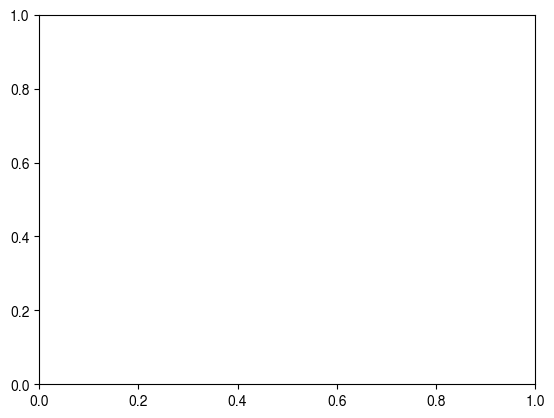

In [29]:
normalise = False
y_axis = "Number of events"
extra_string = basic_extra_string
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Arbitrary Units"


jets = my_data["jets"]

for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    selection = jet_flavour(jets, f)
        
    h_r = Histogram( Displacement_x[selection], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)    
    h_t = Histogram( Displacement_x_truth_tracks[selection], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)    
    truth = Histogram( Truth_Displacement_x[selection], label="Truth", histtype="step", alpha=1)    
    h_st = Histogram( Displacement_x_super_truth_tracks[selection], label = "Vertex Fit (Hadron Truth SV)",  histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="SV Displacement X",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-20,20),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )

    plot_histo.add(truth, reference=True)
    plot_histo.add(h_r, reference=False)
    plot_histo.add(h_t, reference=False)
    plot_histo.add(h_st, reference=False)
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_X_"+flavour+extra_string+".png", transparent=False)


    h_r = Histogram( Displacement_y[selection], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)    
    h_t = Histogram( Displacement_y_truth_tracks[selection], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)    
    truth = Histogram( Truth_Displacement_y[selection], label="Truth", histtype="step", alpha=1)    
    h_st = Histogram( Displacement_y_super_truth_tracks[selection], label = "Vertex Fit (Hadron Truth SV)",  histtype="step", alpha=1)    

    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="SV Displacement Y",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-20,20),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )

    plot_histo.add(truth, reference=True)
    plot_histo.add(h_r, reference=False)
    plot_histo.add(h_t, reference=False)
    plot_histo.add(h_st, reference=False)

        
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_Y_"+flavour+extra_string+".png", transparent=False)


    
    h_r = Histogram( Displacement_z[selection], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)    
    h_t = Histogram( Displacement_z_truth_tracks[selection], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)    
    truth = Histogram( Truth_Displacement_z[selection], label="Truth", histtype="step", alpha=1)    
    h  = Histogram( np.array(truth_vertex_fit[:, 2])[selection], label="Vertex Fit (truth - check)", histtype="step", alpha=1)    
    h_st = Histogram( Displacement_z_super_truth_tracks[selection], label = "Vertex Fit (Hadron Truth SV)",  histtype="step", alpha=1)    
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="SV Displacement Z",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-20,20),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(truth, reference=True)
    plot_histo.add(h_r, reference=False)
    plot_histo.add(h_t, reference=False)
    plot_histo.add(h_st, reference=False)

    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_Z_"+flavour+extra_string+".png", transparent=False)

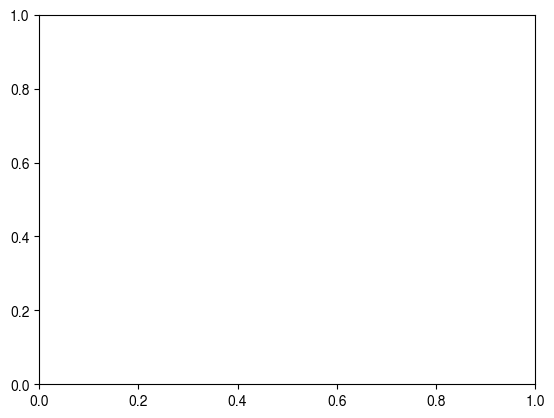

In [30]:
normalise = False
y_axis = "Number of events"
extra_string = basic_extra_string
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Arbitrary Units"


for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    selection = jet_flavour(jets, f)

    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array
    
    h_x = Histogram( error_x[selection], label="Vertex X", histtype="step", alpha=1)    
    h_y = Histogram( error_y[selection], label="Vertex Y", histtype="step", alpha=1)    
    h_z = Histogram( error_z[selection], label="Vertex Z", histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Billoir Vertex Fit with GN2 (Truth - Predicted) [mm]",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-20,20),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(h_x, reference=True)
    plot_histo.add(h_y, reference=False)
    plot_histo.add(h_z, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_"+flavour+extra_string+".png", transparent=False)

    
    h_x = Histogram( significance_x[selection], label="Vertex X", histtype="step", alpha=1)    
    h_y = Histogram( significance_y[selection], label="Vertex Y", histtype="step", alpha=1)    
    h_z = Histogram( significance_z[selection], label="Vertex Z", histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="GN2 Vertex Significance",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-20,20),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(h_x, reference=True)
    plot_histo.add(h_y, reference=False)
    plot_histo.add(h_z, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_Significance_"+flavour+extra_string+"_norm.png", transparent=False)

/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid v

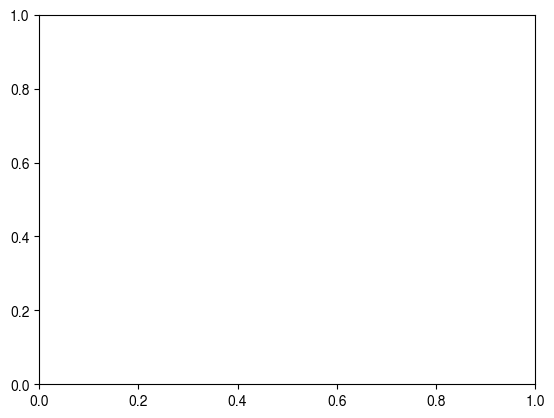

In [31]:
normalise = True
extra_string = basic_extra_string
y_axis = "Number of events"
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Arbitrary Units"


for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    truth_hist = Histogram(Truth_Lxyz[jet_flavour(jets, f)], label="Truth", histtype="step", alpha=1)
    gn2_hist =  Histogram(Lxyz[jet_flavour(jets, f) ], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)
    gn2_perfect_hist =  Histogram(Lxyz_truth_tracks[jet_flavour(jets, f) ], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)
    gn2_super_perfect_hist =  Histogram(Lxyz_super_truth_tracks[jet_flavour(jets, f) ], label="Vertex Fit (Hadron Truth SV)", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_L3d"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement3d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Lxyz [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,80),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_perfect_hist, reference=False)
    plot_histo.add(gn2_super_perfect_hist, reference=False)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Lxyz_"+flavour+extra_string+".png", transparent=False)
    
    truth_hist_v0 = Histogram(jets["HadronConeExclTruthLabelLxy"][jet_flavour(jets, f)], label="Truth HadronConeExclTruthLabelLxy", histtype="step", alpha=1)
    truth_hist = Histogram(Truth_Lxy[jet_flavour(jets, f)], label="Truth", histtype="step", alpha=1)
    gn2_hist =  Histogram(Lxy[jet_flavour(jets, f)], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)
    gn2_perfect_hist =  Histogram(Lxy_truth_tracks[jet_flavour(jets, f)], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)
    gn2_super_perfect_hist =  Histogram(Lxy_super_truth_tracks[jet_flavour(jets, f)], label="Vertex Fit (Hadron Truth SV)", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Lxy [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,40),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_perfect_hist, reference=False)
    plot_histo.add(gn2_super_perfect_hist, reference=False)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)


    plot_histo.draw()

    plot_histo.savefig(output+"Histogram_Lxy_"+flavour+extra_string+".png", transparent=False)






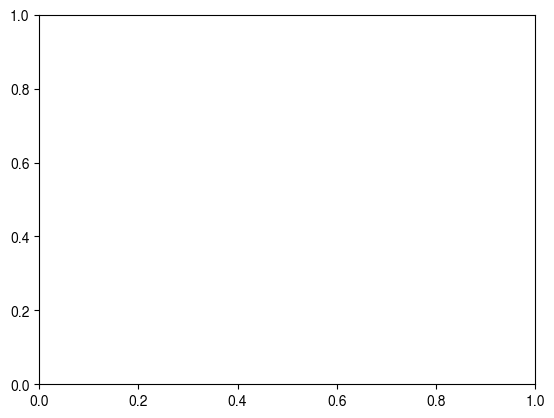

In [32]:

jets = my_data["jets"]

normalise = False
extra_string = basic_extra_string
y_axis = "Number of events"
if normalise: 
    extra_string = basic_extra+"_norm"
    y_axis = "Arbitrary Units"

Lxy_error_GN2_tracks = (Truth_Lxy - Lxy)
Lxy_error_truth_tracks = (Truth_Lxy - Lxy_truth_tracks)
Lxy_error_super_truth_tracks = (Truth_Lxy - Lxy_super_truth_tracks)

SV1_Lxy_error = (Truth_Lxy - jets["SV1_Lxy"])
JetFitter_Lxy_error = (Truth_Lxy - jets["JetFitterSecondaryVertex_displacement2d"])



for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array

    gn2_hist =  Histogram(Lxy_error_GN2_tracks[jet_flavour(jets, f) ], label="Billoir Vertex Fit (GN2 SV finding)", histtype="step", alpha=1)  
    gn2_hist_truth =  Histogram(Lxy_error_truth_tracks[jet_flavour(jets, f) ], label="Billoir Vertex Fit (Truth SV finding)", histtype="step", alpha=1)  
    gn2_hist_super_truth =  Histogram(Lxy_error_super_truth_tracks[jet_flavour(jets, f) ], label="Billoir Vertex Fit (Truth Hadron SV finding)", histtype="step", alpha=1)      
    sv1_hist =  Histogram(SV1_Lxy_error[jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1)  
    jf_hist =  Histogram(JetFitter_Lxy_error[jet_flavour(jets, f) ], label="JetFitter", histtype="step", alpha=1)  
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Lxy Residual [mm]",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-10,10),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_hist_truth, reference=True)
    plot_histo.add(gn2_hist_super_truth, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(jf_hist, reference=False)
    
    
    plot_histo.draw()
    plot_histo.savefig(output+"Histogram_Lxy_Residual_"+flavour+extra_string+".png", transparent=False)


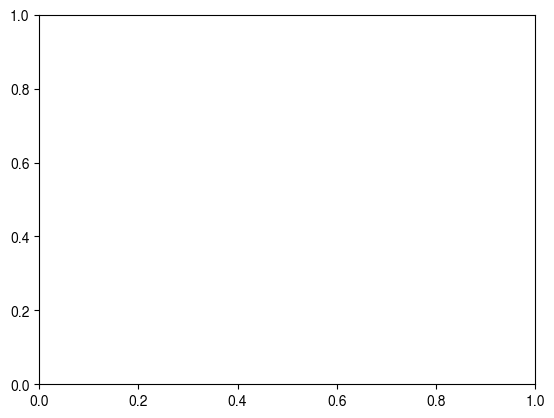

In [33]:


GN2_Lxyz_error = (Truth_Lxyz - Lxyz)
GN2_Lxyz_error_truth = (Truth_Lxyz - Lxyz_truth_tracks)

#GN2_buggy_Lxy_error = (truth_vertex_Lxy - buggy_Lxy)

SV1_Lxyz_error = (Truth_Lxyz - jets["SV1_L3d"])
JetFitter_Lxyz_error = (Truth_Lxyz - jets["JetFitterSecondaryVertex_displacement3d"])



for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array

    gn2_hist =  Histogram(GN2_Lxyz_error[jet_flavour(jets, f)], label="Billoir Vertex Fit (GN2 SV)", histtype="step", alpha=1)  
    gn2_hist_truth =  Histogram(GN2_Lxyz_error_truth[jet_flavour(jets, f)], label="Billoir Vertex Fit (Truth SV)", histtype="step", alpha=1)  

    sv1_hist =  Histogram(SV1_Lxyz_error[jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1)  
    jf_hist =  Histogram(JetFitter_Lxyz_error[jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)  
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="(Truth - Reco) Lxyz [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-40,40),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_hist_truth, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(jf_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Lxyz_Error_"+flavour+extra_string+".png", transparent=False)


In [ ]:
# Other metrics from Johanne's
#     Dictionary containing the following metrics:
#         n_match: np.ndarray
#             Array of shape (n_jets) containing the number of matched vertices per
#             jet.
#         n_test: np.ndarray
#             Array of shape (n_jets) containing the number of reco vetices per jet.
#         n_ref: np.ndarray
#             Array of shape (n_jets) containing the number of truth vertices per jet.
#         track_overlap: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of
#             overlapping tracks between each matched vertex pair.
#         test_vertex_size: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of tracks
#             in each matched reco vertex.
#         ref_vertex_size: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of tracks
#             in each matched truth vertex.


vertex_metrics = calculate_vertex_metrics(reco_vertex_index, truth_vertex_index)

n_reco_vertex = vertex_metrics["n_test"] # 1D (jet)
n_truth_vertex = vertex_metrics["n_ref"] # 1D (jet)

n_reco_tracks_per_vertex = vertex_metrics["test_vertex_size"] # 2D (jet, vertex)
n_truth_tracks_per_vertex = vertex_metrics["ref_vertex_size"]  # 2D (jet, vertex)

In [ ]:
var = np.array(vertex_fit[:, 2])
var_name = "vertex_z_reco"

    
#expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)

# the variable needs to be an array

b_hist = Histogram(var[jet_flavour(jets, "b")], label="b-jets", histtype="step", alpha=1)
c_hist = Histogram(var[jet_flavour(jets, "c")], label="c-jets", histtype="step", alpha=1)
l_hist = Histogram(var[jet_flavour(jets, "light")], label="light", histtype="step", alpha=1)
#sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
#JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)


# Initialise histogram plot
plot_histo = HistogramPlot(
    ylabel="Number of events",
    xlabel="SV z",
    logy=True,
    # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
    bins=40,  # you can also define an integer number for the number of bins
    bins_range=(-30,50),  # only considered if bins is an integer
    norm=False,
    atlas_first_tag="Simulation Internal",
    atlas_second_tag=mc+" "+sample+" ",
    figsize=(6, 3),
    n_ratio_panels=0,
)

#plot_histo.add(truth_hist, reference=True)
plot_histo.add(b_hist, reference=True)
plot_histo.add(c_hist, reference=False)
plot_histo.add(l_hist, reference=False)

#plot_histo.add(sv1_hist, reference=False)
#plot_histo.add(JetFitter_hist, reference=False)


plot_histo.draw()

plot_histo.savefig("Histogram_"+var_name+".png", transparent=False)

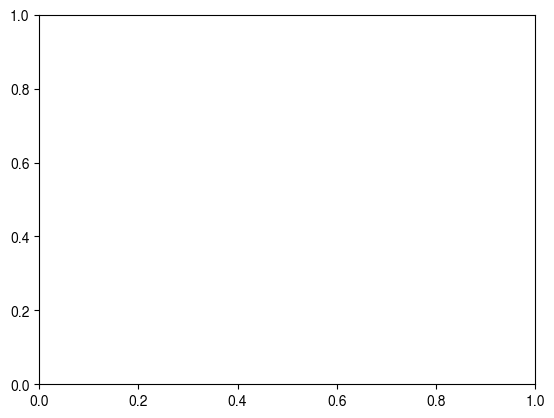

In [42]:
var = n_reco_vertex
var_name = "num_SV_reco"

    
#expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)

# the variable needs to be an array

b_hist = Histogram(var[jet_flavour(jets, "b")], label="b-jets", histtype="step", alpha=1)
c_hist = Histogram(var[jet_flavour(jets, "c")], label="c-jets", histtype="step", alpha=1)
l_hist = Histogram(var[jet_flavour(jets, "light")], label="light-flavour jets", histtype="step", alpha=1)
#sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
#JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)


# Initialise histogram plot
plot_histo = HistogramPlot(
    ylabel="Arbitrary Units",
    xlabel="GN2 (non-inclusive) # SV",
    logy=False,
    # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
    bins=6,  # you can also define an integer number for the number of bins
    bins_range=(0,6),  # only considered if bins is an integer
    norm=True,
    atlas_first_tag="Simulation Internal",
    atlas_second_tag=mc+" "+sample+ ", " + cut_str+" (100k jets)",
    figsize=(6, 3),
    n_ratio_panels=0,
)

#plot_histo.add(truth_hist, reference=True)
plot_histo.add(b_hist, reference=True)
plot_histo.add(c_hist, reference=False)
plot_histo.add(l_hist, reference=False)

#plot_histo.add(sv1_hist, reference=False)
#plot_histo.add(JetFitter_hist, reference=False)


plot_histo.draw()

plot_histo.savefig(output+"Histogram_"+var_name+"_norm.png", transparent=False)

In [ ]:
# Alternative method
# Load tagger instead of opening files with the reader

# Vertexing straight from Tagger (Johanne's style). You can run this cell to produce the vertex plots done by Johanne's for the paper but using your samples. You can then use these to compare to your individual plots as validation of the SV finding part.

GN2 = Tagger(
        name="GN2v01",
        label="GN2v01",
        colour="deepskyblue",
        reference=True,
        aux_tasks=["vertexing", "track_origin"]
)

JetFitter = Tagger(
    name="JF",
    label="JetFitter",
    colour="green",
    reference=False,
    aux_tasks=["vertexing"],
)

SV1 = Tagger(
    name="SV1",
    label="SV1",
    colour="pink",
    reference=False,
    aux_tasks=["vertexing"],
)

aux_results = AuxResults(
      sample=sample + "_" + mc, perf_vars=["pt"], remove_nan=True
)

# load tagger from the file object

taggers = [GN2, SV1, GN2, JetFitter]

aux_results.load_taggers_from_file(
    taggers,
    sample_path,
    cuts=cuts,
    num_jets=n_jets,
)

aux_results.atlas_first_tag = "Simulation Internal"

com = "13" if "MC20" in mc else "13.6"
aux_results.atlas_second_tag = (
    "$\\sqrt{s}=" + com + "$ TeV, " + mc + "\n" + sample_str + ", " + cut_str
)

# Make a plot

aux_results.plot_var_vtx_perf(
    vtx_flavours=["bjets"],
    no_vtx_flavours=["ujets"],
    xlabel=r"$p_{T}$ [GeV]",
    perf_var="pt",
    incl_vertexing=True,
)
